In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [3]:
def Save_Var(data, save_name):
    with open(str(save_name + ".data"), 'wb') as f:
        pickle.dump(data, f)
        
    try:
        with open(str(save_name + ".data"), 'rb') as f:
            new_data = pickle.load(f)
    except:
        print("Error: saving not successful")
    else:
        print(str(save_name + ".data" + " saved succesfully"))

def Load_Var(save_name):
    with open(save_name, 'rb') as f:
        data = pickle.load(f)
    return data

In [4]:
matched_ids = Load_Var('matched_stations.data')

In [5]:
def Process_TextFiles(infile_path, outfile_path):
    # Read input file while removing characters after numeric values
    replacements = {
        '-' : ' -',  # missing values '-9999.9M' are not separated by a space in raw files
        'a' : '', # adjusted value
        'E' : '', # indicates estimated value
        'e' : '', # typo in some txt files
        'h' : ''  # same as above
    }
    with open(infile_path) as infile, open(outfile_path, 'w') as outfile:
        for line in infile:
            for src, target in replacements.items():
                line = line.replace(src, target)
            outfile.write(line) 
            
    # load edited output file
    df = pd.read_csv(outfile_path, header=2, delim_whitespace=True)
    
    # First row is French column names
    df.drop(0, axis=0, inplace=True) 
    
    # Columns after 33 are duplicated because column names are separated by a space
    df = df.iloc[:, :33]
    
    # Add an extra column indicating station name (can be used as merge id later on)
    df['Station'] = outfile_path.split("\\")[1][2:9]
    
    # Fix column names
    days = np.arange(1,32,1)
    days = [str(i).zfill(2) for i in days]
    new_cols = ['Year', 'Mo'] + days
    df.rename(dict(zip(list(df.columns), new_cols)), axis='columns', inplace=True)
    
    df = df.replace('-9999.9M', np.nan)
    df = df.replace('-9999.9e', np.nan)
    df = df.replace('-9999.9', np.nan)
#     df = df.apply(lambda x: x.str.strip())
    df.iloc[:, :-1] = df.iloc[:, :-1].astype(float)
    
    return df

In [6]:
def Combine_TextFiles(in_directory, out_directory, verbose=False):
    dfs = []
    for file in os.listdir(in_directory):
        filename = os.fsdecode(file)
        if filename.endswith(".txt") and str(filename)[2:-4] in matched_ids:
            if verbose is True:
                print(os.path.join(in_directory, filename))
            dfs.append(
                Process_TextFiles(os.path.join(in_directory, filename), os.path.join(out_directory, filename)))
        else:
            continue
    return pd.concat(dfs)

In [7]:
max_in = 'Homog_daily_max_temp_v2019'
max_out = 'Homog_daily_max_temp_v2019_'

min_in = 'Homog_daily_min_temp_v2019'
min_out = 'Homog_daily_min_temp_v2019_'

mean_in = 'Homog_daily_mean_temp_v2019'
mean_out = 'Homog_daily_mean_temp_v2019_'

In [8]:
max_df = Combine_TextFiles(max_in, max_out)
min_df = Combine_TextFiles(min_in, min_out)
mean_df = Combine_TextFiles(mean_in, mean_out)

In [9]:
# max_df.to_csv('processed_max.csv', index=False)
# min_df.to_csv('processed_min.csv', index=False)
# mean_df.to_csv('processed_mean.csv', index=False)

In [9]:
max_df.head()

Year  Mo    01    02    03    04    05    06    07    08  ...    23    24  \
1  1913  10  14.7  14.7  15.2  12.2  14.7  11.1   5.3  11.1  ...  12.2  13.4   
2  1913  11   9.6  10.1  10.6   8.5   8.5     8  10.6   5.3  ...   4.8   7.4   
3  1913  12     8   7.4   6.3   3.7   4.8   5.8   5.8   5.8  ...   5.3   4.8   
4  1914   1   5.8   7.4   8.5     9   9.6     9   6.9   6.3  ...   2.7   3.7   
5  1914   2     8   5.3   2.2   1.6   4.8     0     0   2.7  ...     9   6.9   

     25   26    27    28   29   30    31  Station  
1  11.7  9.6   9.6     9    9    9  10.6  1012010  
2   8.5    8  10.6   6.3    8  7.4   NaN  1012010  
3   5.3  4.3   6.3   5.3  5.8  4.3   6.9  1012010  
4   1.1  3.7   3.3   1.6  2.2  4.3   4.3  1012010  
5     8  7.4     8  11.1  NaN  NaN   NaN  1012010  

[5 rows x 34 columns]

In [10]:
mean_df.head()

Year  Mo    01   02   03   04   05   06   07   08  ...    23    24   25  \
1  1913  10  10.2   12   11  8.4  8.1  8.1  6.3  8.1  ...  11.1  11.3  7.8   
2  1913  11   6.8  6.2  6.3    5  6.8  6.3  6.3  4.3  ...   3.4   5.4  8.2   
3  1913  12   6.6  5.7  3.3  2.3  3.6  5.5  3.9  3.6  ...   3.6   2.6  3.4   
4  1914   1   4.6  7.1  6.5  7.9  8.8  9.1  5.7  4.8  ...   1.8   2.6  1.3   
5  1914   2   4.2  2.8    1  1.5 -0.1 -2.2  0.2  2.3  ...   7.4   7.1  4.7   

    26   27   28   29   30   31  Station  
1  6.5  6.5  6.8  5.9  5.2  6.3  1012010  
2  6.6  7.6  5.7  7.4  5.4  NaN  1012010  
3  3.5  6.2  3.6  3.9  2.9  6.3  1012010  
4    3  0.6 -1.2 -0.6  2.9  3.1  1012010  
5  4.7  5.4  8.1  NaN  NaN  NaN  1012010  

[5 rows x 34 columns]

In [11]:
min_df.head()

Year  Mo   01   02   03   04   05   06   07   08  ...   23   24   25   26  \
1  1913  10  5.7  9.2  6.7  4.5  1.4  5.1  7.3  5.1  ...   10  9.2  3.9  3.3   
2  1913  11  3.9  2.3  1.9  1.4  5.1  4.5  1.9  3.3  ...  1.9  3.3  7.9  5.1   
3  1913  12  5.1  3.9  0.3  0.9  2.3  5.1  1.9  1.4  ...  1.9  0.3  1.4  2.7   
4  1914   1  3.3  6.7  4.5  6.7  7.9  9.2  4.5  3.3  ...  0.9  1.4  1.4  2.3   
5  1914   2  0.3  0.3 -0.3  1.4   -5 -4.4  0.3  1.9  ...  5.7  7.3  1.4  1.9   

    27   28   29   30   31  Station  
1  3.3  4.5  2.7  1.4  1.9  1012010  
2  4.5  5.1  6.7  3.3  NaN  1012010  
3  6.1  1.9  1.9  1.4  5.7  1012010  
4 -2.1 -3.9 -3.3  1.4  1.9  1012010  
5  2.7  5.1  NaN  NaN  NaN  1012010  

[5 rows x 34 columns]

In [12]:
def Format_Data(df, temp_type, start_year='beginning'):
    temp = df.copy()
    print("Full Data Size:", temp.shape)
    if start_year != 'beginning':
        temp = temp[temp['Year'] >= start_year]
        print("Data Size ({} onwards):".format(start_year))
    temp = temp.melt(
        id_vars=['Station', 'Year', 'Mo'],
        var_name="Day",
        value_name=temp_type
    )
    print("Data Shape (After Melting):", temp.shape)
    temp.rename({'Mo':'Month'}, axis=1, inplace=True)
    temp['Date'] = pd.to_datetime(temp[['Year', 'Month', 'Day']], errors='coerce')
    temp = temp.drop(['Year', 'Month', 'Day'], axis=1)
    print("Data Shape (After adding datetime column):", temp.shape)
    temp = temp[~temp['Date'].isnull()]
    print("Data Shape (After removing invalid dates):", temp.shape)
    temp[temp_type] = temp[temp_type].astype(float)
    return temp

In [13]:
def Examine_Nulls(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    return missing_value_df

# def Fill_Nulls(df, temp_type):
#     df_filled = df.set_index(['Date'])
#     df_filled = df_filled.groupby('Station').resample('D').mean()
#     df_filled[temp_type] = df_filled[temp_type].interpolate()
#     return df_filled

In [14]:
minz = Format_Data(min_df, "Min_Temp")
minz.head()

Full Data Size: (306918, 34)
Data Shape (After Melting): (9514458, 5)
Data Shape (After adding datetime column): (9514458, 3)
Data Shape (After removing invalid dates): (9341823, 3)


Station  Min_Temp       Date
0  1012010       5.7 1913-10-01
1  1012010       3.9 1913-11-01
2  1012010       5.1 1913-12-01
3  1012010       3.3 1914-01-01
4  1012010       0.3 1914-02-01

In [ ]:
np.unique(minz['Station']).shape

In [ ]:
maxz = Format_Data(max_df, "Max_Temp")
maxz.head()

In [ ]:
meanz = Format_Data(mean_df, "Mean_Temp")
meanz.head()

In [19]:
# maxz_filled = Fill_Nulls(maxz, 'Max_Temp')
# Examine_Nulls(maxz_filled)

In [20]:
# minz_filled = Fill_Nulls(minz, 'Min_Temp')
# Examine_Nulls(minz_filled)

In [ ]:
# minz_filled, maxz_filled = minz_filled.reset_index(), maxz_filled.reset_index()
full_df = pd.merge(meanz, pd.merge(maxz, minz))
full_df.set_index(['Station', 'Date'], inplace=True)
full_df

In [ ]:
Examine_Nulls(full_df)

In [ ]:
full_df_ = full_df.dropna()
full_df_.shape

In [ ]:
ii = full_df_.reset_index()

In [ ]:
ii['Station'] = ii['Station'].astype(str)
np.unique(ii['Station']).shape

In [26]:
# full_df_.to_csv("AHCCD_full.csv")

## Data Exploration

In [29]:
full_df_.describe()

Mean_Temp      Max_Temp      Min_Temp
count  8.560161e+06  8.560161e+06  8.560161e+06
mean   4.021543e+00  9.432814e+00 -1.406092e+00
std    1.242778e+01  1.321354e+01  1.221511e+01
min   -5.610000e+01 -5.390000e+01 -6.000000e+01
25%   -3.400000e+00  1.000000e+00 -7.800000e+00
50%    5.800000e+00  1.050000e+01  6.000000e-01
75%    1.380000e+01  2.000000e+01  7.600000e+00
max    3.670000e+01  4.750000e+01  3.300000e+01

In [31]:
print("Lowest Minimum Temp:", full_df_['Min_Temp'].min())
print("Lowest Maximum Temp:", full_df_['Max_Temp'].min())
print("Lowest Mean Temp:", full_df_['Mean_Temp'].min())

print("Highest Minimum Temp:", full_df_['Min_Temp'].max())
print("Highest Maximum Temp:", full_df_['Max_Temp'].max())
print("Highest Mean Temp:", full_df_['Mean_Temp'].max())

Lowest Minimum Temp: -60.0
Lowest Maximum Temp: -53.9
Lowest Mean Temp: -56.1
Highest Minimum Temp: 33.0
Highest Maximum Temp: 47.5
Highest Mean Temp: 36.7


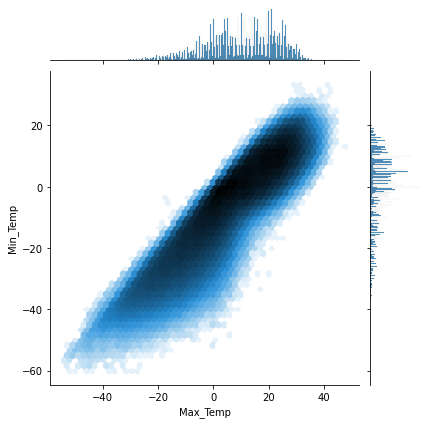

In [32]:
sns.jointplot(x=full_df_['Max_Temp'], y=full_df_['Min_Temp'], kind='hex', bins='log')

In [24]:
ii = full_df.sort_index().reset_index()
ii = ii[ii['Station']=='8504177']

Text(0, 0.5, 'Temperature')

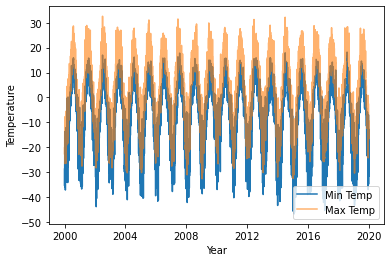

In [25]:
plt.plot(ii['Date'], ii['Min_Temp'], label='Min Temp')
plt.plot(ii['Date'], ii['Max_Temp'], alpha=0.6, label='Max Temp')
plt.legend(loc='lower right')
plt.xlabel('Year')
plt.ylabel('Temperature')

In [26]:
# ii['Date'] = ii['Date'].dt.to_pydatetime()
# groups = ii.groupby(ii.Date.dt.year)['Max_Temp']
# i=1
# for name, group in groups:
#     plt.subplot(20, 1, i)
#     plt.plot(group.values)
#     plt.xticks(())
#     i+=1
# # years.plot(subplots=True, legend=False)
# # plt.show()